# Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Carga

In [2]:
# Cargar conjuntos de datos
train_csv = pd.read_csv('data/train.csv')
validation_csv = pd.read_csv('data/validation.csv')
test_csv = pd.read_csv('data/test.csv')

# Separar datos y etiquetas
feature_cols = train_csv.columns.values.tolist()[1:]
X_train = train_csv[feature_cols]
y_train = train_csv['RiskPerformance']
X_validation = validation_csv[feature_cols]
y_validation = validation_csv['RiskPerformance']
X_test = test_csv[feature_cols]
y_test = test_csv['RiskPerformance']

In [3]:


# Crear y entrenar el modelo EBM
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

#Predecir en el conjunto de entrenamiento
y_pred_train_ebm = ebm.predict(X_train)
train_accuracy_ebm = round(accuracy_score(y_train, y_pred_train_ebm), 4)
print('Train accuracy (EBM):', train_accuracy_ebm)

# Predecir en el conjunto de validación
y_pred_validation_ebm = ebm.predict(X_validation)
validation_accuracy_ebm = round(accuracy_score(y_validation, y_pred_validation_ebm), 4)
print('Validation accuracy (EBM):', validation_accuracy_ebm)


Train accuracy (EBM): 0.7459
Validation accuracy (EBM): 0.7145


## Estudio de Hiperparámetros

Celda comentada pues el tiempo de ejecución es muy alto. En caso de querer ejecutar, descomentar el código

In [71]:
"""

params_grid = {
    'smoothing_rounds': [50, 100, 200, 500, 1000, 2000, 4000],
    'interactions': [0.5, 0.75, 0.9, 5, 10],
    'inner_bags': [0, 1, 2],
    'max_bins': [1024, 4096, 16384, 65536]
}

# Crear el modelo EBM
ebm = ExplainableBoostingClassifier()

# Configurar GridSearchCV
grid_search_ebm = GridSearchCV(estimator=ebm, param_grid=params_grid, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo con GridSearchCV
grid_search_ebm.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search_ebm.best_params_
print("Mejores hiperparámetros:", best_params)
print("Mejor accuracy:", round(grid_search_ebm.best_score_, 4))

"""

Mejores hiperparámetros: {'inner_bags': 0, 'interactions': 10, 'max_bins': 1024, 'smoothing_rounds': 50}
Mejor accuracy: 0.7334


Mejores hiperparámetros: {'inner_bags': 0, 'interactions': 10, 'max_bins': 1024, 'smoothing_rounds': 50}
Mejor accuracy: 0.7334

# Entrenamiento del modelo

Usados:

{'inner_bags': 0,
 'interactions': 10,
 'max_bins': 1024,
 'smoothing_rounds': 50}

In [4]:
# Crear el modelo EBM con los mejores hiperparámetros
ebm_final = ExplainableBoostingClassifier(inner_bags=0, interactions=10, max_bins=1024, smoothing_rounds=50, feature_names=feature_cols)

# Entrenar el modelo
ebm_final.fit(X_train, y_train)

y_pred_train = ebm_final.predict(X_train)
y_pred_validation = ebm_final.predict(X_validation)

# Evaluar el rendimiento del modelo
train_accuracy = round(accuracy_score(y_train, y_pred_train), 4)
validation_accuracy = round(accuracy_score(y_validation, y_pred_validation), 4)
print('Accuracy entrenamiento:', train_accuracy)
print('Accuracy validación:', validation_accuracy)

Accuracy entrenamiento: 0.7436
Accuracy validación: 0.7115


## Métricas de evaluación

In [13]:
y_pred_test = ebm_final.predict(X_test)

test_accuracy = round(accuracy_score(y_test, y_pred_test), 4)
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.7436
Test accuracy: 0.7489


In [14]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

         Bad       0.76      0.77      0.77      1015
        Good       0.73      0.72      0.73       873

    accuracy                           0.75      1888
   macro avg       0.75      0.75      0.75      1888
weighted avg       0.75      0.75      0.75      1888



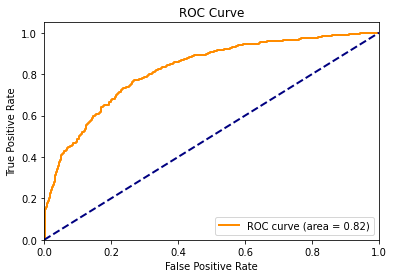

ROC AUC: 0.8215


In [15]:
# Graficar la curva ROC usando las variables existentes
y_pred_proba = ebm_final.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test.map({'Bad': 0, 'Good': 1}), y_pred_proba)
roc_auc = roc_auc_score(y_test.map({'Bad': 0, 'Good': 1}), y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:', round(roc_auc, 4))

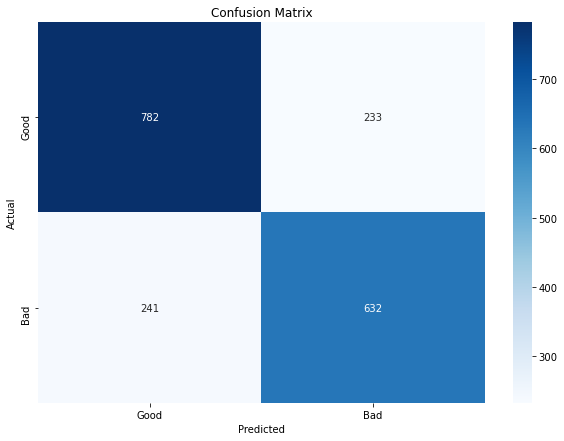

In [8]:

conf_matrix = confusion_matrix(y_test, y_pred_test)

# Dibujar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Explicabilidad del modelo

## Explicabilidad global

In [9]:
ebm_global = ebm_final.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/2371705790864/ -->

## Interpretabilidad local

In [10]:
X_test[:20]

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,69,256,6,117,11,1,1,100,-7,7,...,8,0,0,0,13,-8,2,-8,0,67
1,61,256,19,68,14,0,0,87,0,4,...,33,0,2,1,62,68,3,3,1,86
2,70,37,4,20,19,0,0,100,-7,7,...,20,0,3,3,42,73,2,2,1,50
3,73,255,16,100,40,0,0,100,-7,7,...,23,0,1,1,79,-8,18,1,13,80
4,83,398,3,118,29,0,0,100,-7,7,...,31,0,3,3,22,87,6,3,0,69
5,65,478,12,97,44,0,0,89,1,4,...,32,0,9,9,63,-8,9,-8,6,60
6,78,368,6,74,42,0,0,98,23,5,...,49,0,3,3,10,19,8,2,0,67
7,71,282,1,73,22,0,0,96,-8,6,...,4,0,2,2,37,39,11,1,1,80
8,50,204,2,91,23,2,0,82,1,3,...,32,0,6,6,32,-8,5,-8,0,67
9,62,151,19,99,5,1,1,80,16,6,...,80,0,0,0,40,75,1,2,0,100


In [11]:
y_test[:20]

0     Good
1      Bad
2      Bad
3      Bad
4     Good
5      Bad
6      Bad
7      Bad
8      Bad
9      Bad
10     Bad
11    Good
12    Good
13     Bad
14     Bad
15     Bad
16     Bad
17    Good
18     Bad
19     Bad
Name: RiskPerformance, dtype: object

In [12]:
ebm_local = ebm_final.explain_local(X_test[:20], y_test[:20], name='EBM')
show(ebm_local, 0)

<!-- http://127.0.0.1:7001/2371225955200/ -->

## Modelos de caja negra

In [19]:
random_forest = RandomForestClassifier(random_state=RANDOM_STATE)

# Entrenar el modelo
random_forest.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_pred_validation_rf = random_forest.predict(X_validation)

# Evaluar el rendimiento del modelo
validation_accuracy_rf = accuracy_score(y_validation, y_pred_validation_rf)
print('Validation accuracy (Random Forest):', validation_accuracy_rf)

Validation accuracy (Random Forest): 0.7095


In [70]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 2000, num = 40)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 50, 100, 200, None]
}

RF_randomizedSearch = RandomForestClassifier()
randomized_search = RandomizedSearchCV(RF_randomizedSearch, param_grid, random_state=RANDOM_STATE, n_jobs=-1, n_iter = 100, scoring='accuracy')

randomized_search.fit(X_train, y_train)

best_params_rf = randomized_search.best_params_
print("Mejores hiperparámetros:", best_params_rf)
print("Mejor accuracy:", randomized_search.best_score_)

Mejores hiperparámetros: {'n_estimators': 1850, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini'}
Mejor accuracy: 0.7298341938593694


Mejores hiperparámetros: {'n_estimators': 1500, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'log_loss'}
Mejor accuracy: 0.7287508423402792

In [73]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 2000, num = 40)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 50, 100, 200, None]
}

RF_randomizedSearch = RandomForestClassifier()
randomized_search = RandomizedSearchCV(RF_randomizedSearch, param_grid, random_state=RANDOM_STATE, n_jobs=-1, n_iter = 500, scoring='accuracy')

randomized_search.fit(X_train, y_train)

best_params_rf = randomized_search.best_params_
print("Mejores hiperparámetros:", best_params_rf)
print("Mejor accuracy:", randomized_search.best_score_)

Mejores hiperparámetros: {'n_estimators': 600, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'log_loss'}
Mejor accuracy: 0.730918504627176


Mejores hiperparámetros: {'n_estimators': 600, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'log_loss'}
Mejor accuracy: 0.730918504627176

In [27]:
random_forest_final = RandomForestClassifier(n_estimators=600, max_features = 'log2', max_depth = 100, criterion = 'log_loss', random_state=RANDOM_STATE)

# Entrenar el modelo
random_forest_final.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=100, max_features='log2',
                       n_estimators=600, random_state=123)

In [29]:

y_pred_train_rf = random_forest_final.predict(X_train)
y_pred_test_rf = random_forest_final.predict(X_test)

# Evaluar el rendimiento del modelo
train_accuracy_rf = round(accuracy_score(y_train, y_pred_train_rf), 4)
print('Train accuracy (Random Forest):', train_accuracy_rf)

test_accuracy_rf = round(accuracy_score(y_test, y_pred_test_rf), 4)
print('Test accuracy:', test_accuracy_rf)

report_rf = classification_report(y_test, y_pred_test_rf)
print(report_rf)


Train accuracy (Random Forest): 0.9748
Test accuracy: 0.7341
              precision    recall  f1-score   support

         Bad       0.74      0.78      0.76      1015
        Good       0.72      0.68      0.70       873

    accuracy                           0.73      1888
   macro avg       0.73      0.73      0.73      1888
weighted avg       0.73      0.73      0.73      1888



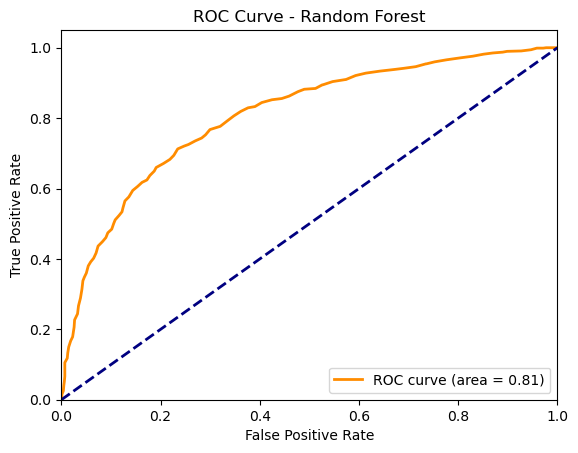

ROC AUC (Random Forest): 0.8061


In [24]:
# Graficar la curva ROC usando las variables existentes para random_forest
y_pred_proba_rf = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test.map({'Bad': 0, 'Good': 1}), y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test.map({'Bad': 0, 'Good': 1}), y_pred_proba_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Calcular ROC AUC para random_forest
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print('ROC AUC (Random Forest):', round(roc_auc_rf, 4))